# Weapon Accuracy

## Setting Up

In [1]:
import pandas as pd
from weapon import max_shots, burst
from probability import at_least_one_hit

weapon_stats = pd.read_csv("datasets/weapon_stats.csv")
ammo_stats = pd.read_csv("datasets/ammo_stats.csv")
weapon_firemodes = pd.read_csv("datasets/weapon_firemodes.csv")

# Data Merge

In [2]:
weapon_attacks = weapon_stats.merge(ammo_stats, on="weapon")
weapon_attacks = weapon_attacks.merge(weapon_firemodes, on="weapon")
weapon_attacks.head()

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy
0,pistol,1,pistol_clip,26,armor_piercing,12.0,snapshot,18,60
1,pistol,1,pistol_clip,26,armor_piercing,12.0,aimed,30,78
2,rifle,2,rifle_clip,30,armor_piercing,20.0,auto,35,35
3,rifle,2,rifle_clip,30,armor_piercing,20.0,snapshot,25,60
4,rifle,2,rifle_clip,30,armor_piercing,20.0,aimed,80,110


# Accuracy Range

Soldiers start with an Accuracy value between 40 and 70. But the attribute may go up to 120. So we are going to prepare a set moving between 40 and 120.

As the average Accuracy for new soldiers is 55 we add this as one of the values.

In [3]:
data = [40, 50, 55, 60, 80, 90, 100, 110, 120]
accuracy_range = pd.DataFrame(data, columns = ["soldier_accuracy"])
accuracy_range

,soldier_accuracy
0,40
1,50
2,55
3,60
4,80
5,90
6,100
7,110
8,120


## Merging With Weapons

In [4]:
weapon_attacks_proficiency = weapon_attacks
weapon_attacks_proficiency = weapon_attacks_proficiency.append([weapon_attacks_proficiency] * (len(accuracy_range.index)-1), ignore_index=True)
weapon_attacks_proficiency["key"] = weapon_attacks_proficiency.groupby(["weapon", "ammo", "fire_mode"]).cumcount()

weapon_attacks_proficiency = pd.merge(weapon_attacks_proficiency, accuracy_range, left_on="key", right_index=True, how="left", sort=False)
weapon_attacks_proficiency = weapon_attacks_proficiency.drop(columns=["key"])
weapon_attacks_proficiency

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,soldier_accuracy
0,pistol,1,pistol_clip,26,armor_piercing,12.0,snapshot,18,60,40
1,pistol,1,pistol_clip,26,armor_piercing,12.0,aimed,30,78,40
2,rifle,2,rifle_clip,30,armor_piercing,20.0,auto,35,35,40
3,rifle,2,rifle_clip,30,armor_piercing,20.0,snapshot,25,60,40
4,rifle,2,rifle_clip,30,armor_piercing,20.0,aimed,80,110,40
...,...,...,...,...,...,...,...,...,...,...
535,laser_turret,2,laser_beam,110,laser,255.0,snapshot,75,85,120
536,laser_turret,2,laser_beam,110,laser,255.0,aimed,33,50,120
537,plasma_turret,2,plasma,110,plasma,255.0,snapshot,30,85,120
538,plasma_turret,2,plasma,110,plasma,255.0,aimed,60,100,120


## Final Accuracy

For our needs the accuracy formula is just the weapon accuracy multiplied by the soldier accuracy.

In [5]:
weapon_attacks_proficiency["final_accuracy"] = weapon_attacks_proficiency.apply(lambda x: x["accuracy"] * x["soldier_accuracy"] / 10000, axis=1)
weapon_attacks_proficiency

,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,soldier_accuracy,final_accuracy
0,pistol,1,pistol_clip,26,armor_piercing,12.0,snapshot,18,60,40,0.240
1,pistol,1,pistol_clip,26,armor_piercing,12.0,aimed,30,78,40,0.312
2,rifle,2,rifle_clip,30,armor_piercing,20.0,auto,35,35,40,0.140
3,rifle,2,rifle_clip,30,armor_piercing,20.0,snapshot,25,60,40,0.240
4,rifle,2,rifle_clip,30,armor_piercing,20.0,aimed,80,110,40,0.440
...,...,...,...,...,...,...,...,...,...,...,...
535,laser_turret,2,laser_beam,110,laser,255.0,snapshot,75,85,120,1.020
536,laser_turret,2,laser_beam,110,laser,255.0,aimed,33,50,120,0.600
537,plasma_turret,2,plasma,110,plasma,255.0,snapshot,30,85,120,1.020
538,plasma_turret,2,plasma,110,plasma,255.0,aimed,60,100,120,1.200


# Weapon Accuracies On Average

In [6]:
weapon_proficiency_development_average = weapon_attacks_proficiency[["weapon", "fire_mode", "soldier_accuracy", "final_accuracy"]]
weapon_proficiency_development_average = weapon_proficiency_development_average.groupby(["weapon", "soldier_accuracy"]).mean()
weapon_proficiency_development_average = weapon_proficiency_development_average.sort_values(by=["weapon"])
weapon_proficiency_development_average

final_accuracy
weapon        soldier_accuracy                
alien_grenade 40                        0.2600
              50                        0.3250
              55                        0.3575
              60                        0.3900
              80                        0.5200
...                                        ...
stun_rod      60                        0.6000
              80                        0.8000
              90                        0.9000
              100                       1.0000
              120                       1.2000

[207 rows x 1 columns]

## Kinetic Weapons

Text(0, 0.5, 'Final accuracy')

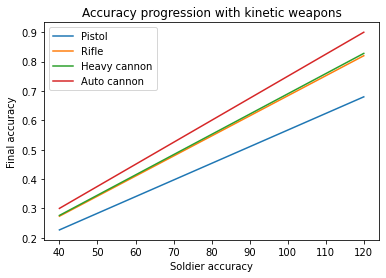

In [7]:
weapon_proficiency_development_average_kinetic = weapon_proficiency_development_average.loc[ ["pistol", "rifle", "heavy_cannon", "auto_cannon"] ]
weapon_proficiency_development_average_kinetic = weapon_proficiency_development_average_kinetic.sort_values(by=["final_accuracy"])
weapon_proficiency_development_average_kinetic = weapon_proficiency_development_average_kinetic.unstack(level=0)
ax = weapon_proficiency_development_average_kinetic.plot(title="Accuracy progression with kinetic weapons")
ax.legend(["Pistol", "Rifle", "Heavy cannon", "Auto cannon"]);
ax.set_xlabel("Soldier accuracy")
ax.set_ylabel("Final accuracy")

## Melee

Text(0, 0.5, 'Final accuracy')

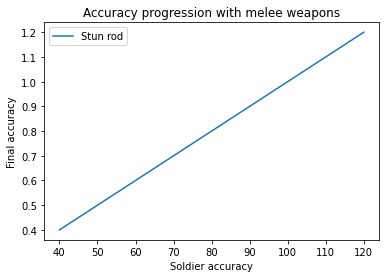

In [8]:
weapon_proficiency_development_average_melee = weapon_proficiency_development_average.loc[ ["stun_rod"] ]
weapon_proficiency_development_average_melee = weapon_proficiency_development_average_melee.sort_values(by=["final_accuracy"])
weapon_proficiency_development_average_melee = weapon_proficiency_development_average_melee.unstack(level=0)
ax = weapon_proficiency_development_average_melee.plot(title="Accuracy progression with melee weapons")
ax.legend(["Stun rod"]);
ax.set_xlabel("Soldier accuracy")
ax.set_ylabel("Final accuracy")

## Explosive

Text(0, 0.5, 'Final accuracy')

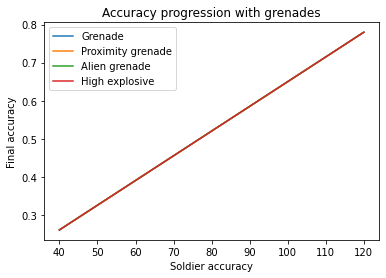

In [9]:
weapon_proficiency_development_average_grenade = weapon_proficiency_development_average.loc[ ["grenade", "proximity_grenade", "alien_grenade", "high_explosive"] ]
weapon_proficiency_development_average_grenade = weapon_proficiency_development_average_grenade.sort_values(by=["final_accuracy"])
weapon_proficiency_development_average_grenade = weapon_proficiency_development_average_grenade.unstack(level=0)
ax = weapon_proficiency_development_average_grenade.plot(title="Accuracy progression with grenades")
ax.legend(["Grenade", "Proximity grenade", "Alien grenade", "High explosive"]);
ax.set_xlabel("Soldier accuracy")
ax.set_ylabel("Final accuracy")

Text(0, 0.5, 'Final accuracy')

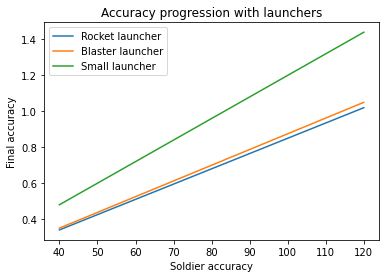

In [10]:
weapon_proficiency_development_average_launcher = weapon_proficiency_development_average.loc[ ["rocket_launcher", "blaster_launcher", "small_launcher"] ]
weapon_proficiency_development_average_launcher = weapon_proficiency_development_average_launcher.sort_values(by=["final_accuracy"])
weapon_proficiency_development_average_launcher = weapon_proficiency_development_average_launcher.unstack(level=0)
ax = weapon_proficiency_development_average_launcher.plot(title="Accuracy progression with launchers")
ax.legend(["Rocket launcher", "Blaster launcher", "Small launcher"]);
ax.set_xlabel("Soldier accuracy")
ax.set_ylabel("Final accuracy")

## Laser

Text(0, 0.5, 'Final accuracy')

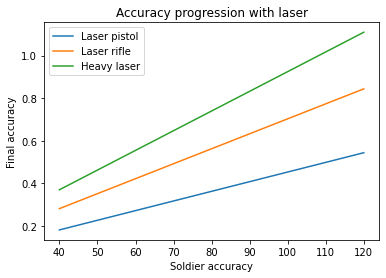

In [11]:
weapon_proficiency_development_average_laser = weapon_proficiency_development_average.loc[ ["laser_pistol", "laser_rifle", "heavy_laser"] ]
weapon_proficiency_development_average_laser = weapon_proficiency_development_average_laser.sort_values(by=["final_accuracy"])
weapon_proficiency_development_average_laser = weapon_proficiency_development_average_laser.unstack(level=0)
ax = weapon_proficiency_development_average_laser.plot(title="Accuracy progression with laser")
ax.legend(["Laser pistol", "Laser rifle", "Heavy laser"]);
ax.set_xlabel("Soldier accuracy")
ax.set_ylabel("Final accuracy")

## Plasma

Text(0, 0.5, 'Final accuracy')

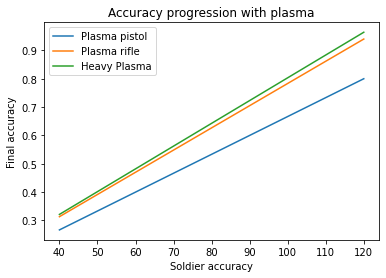

In [12]:
weapon_proficiency_development_average_plasma = weapon_proficiency_development_average.loc[ ["plasma_pistol", "plasma_rifle", "heavy_plasma"] ]
weapon_proficiency_development_average_plasma = weapon_proficiency_development_average_plasma.sort_values(by=["final_accuracy"])
weapon_proficiency_development_average_plasma = weapon_proficiency_development_average_plasma.unstack(level=0)
ax = weapon_proficiency_development_average_plasma.plot(title="Accuracy progression with plasma")
ax.legend(["Plasma pistol", "Plasma rifle", "Heavy Plasma"]);
ax.set_xlabel("Soldier accuracy")
ax.set_ylabel("Final accuracy")

## Tank

Tanks don't increase skills. But the calculations are included.

Text(0, 0.5, 'Final accuracy')

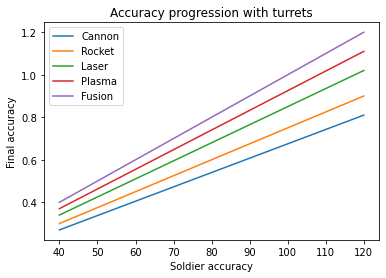

In [13]:
weapon_proficiency_development_average_turret = weapon_proficiency_development_average.loc[ ["cannon_turret", "rocket_turret", "laser_turret", "plasma_turret", "fusion_turret"] ]
weapon_proficiency_development_average_turret = weapon_proficiency_development_average_turret.sort_values(by=["final_accuracy"])
weapon_proficiency_development_average_turret = weapon_proficiency_development_average_turret.unstack(level=0)
ax = weapon_proficiency_development_average_turret.plot(title="Accuracy progression with turrets")
ax.legend(["Cannon", "Rocket", "Laser", "Plasma", "Fusion"]);
ax.set_xlabel("Soldier accuracy")
ax.set_ylabel("Final accuracy")

# At Least One Hit

Having the max number of shots a weapon can make on a turn. What is the chance of getting at least one hit?

In [14]:
weapon_attacks_proficiency["burst"] = weapon_attacks_proficiency.apply(burst, axis=1)
weapon_attacks_proficiency["turn_max_shots"] = weapon_attacks_proficiency.apply(max_shots, axis=1)
weapon_attacks_proficiency["at_least_one"] = weapon_attacks_proficiency.apply(at_least_one_hit, axis=1)
weapon_attacks_proficiency

D:\PycharmProjects\xcom-analysis-jupyter-notebook\enemy_unknown\probability.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(np.complex128(chance))


,weapon,grip,ammo,damage,damage_type,capacity,fire_mode,time_units,accuracy,soldier_accuracy,final_accuracy,burst,turn_max_shots,at_least_one
0,pistol,1,pistol_clip,26,armor_piercing,12.0,snapshot,18,60,40,0.240,1,5,0.746447
1,pistol,1,pistol_clip,26,armor_piercing,12.0,aimed,30,78,40,0.312,1,3,0.674339
2,rifle,2,rifle_clip,30,armor_piercing,20.0,auto,35,35,40,0.140,3,6,0.595433
3,rifle,2,rifle_clip,30,armor_piercing,20.0,snapshot,25,60,40,0.240,1,4,0.666378
4,rifle,2,rifle_clip,30,armor_piercing,20.0,aimed,80,110,40,0.440,1,1,0.440000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,laser_turret,2,laser_beam,110,laser,255.0,snapshot,75,85,120,1.020,1,1,1.000000
536,laser_turret,2,laser_beam,110,laser,255.0,aimed,33,50,120,0.600,1,3,0.936000
537,plasma_turret,2,plasma,110,plasma,255.0,snapshot,30,85,120,1.020,1,3,1.000000
538,plasma_turret,2,plasma,110,plasma,255.0,aimed,60,100,120,1.200,1,1,1.000000


## Averages

In [15]:
weapon_proficiency_development_one = weapon_attacks_proficiency[["weapon", "fire_mode", "soldier_accuracy", "at_least_one"]]
weapon_proficiency_development_one = weapon_proficiency_development_one.groupby(["weapon", "soldier_accuracy"]).mean()
weapon_proficiency_development_one = weapon_proficiency_development_one.sort_values(by=["weapon"])
weapon_proficiency_development_one

at_least_one
weapon        soldier_accuracy              
alien_grenade 40                      0.2600
              50                      0.3250
              55                      0.3575
              60                      0.3900
              80                      0.5200
...                                      ...
stun_rod      60                      0.9360
              80                      0.9920
              90                      0.9990
              100                     1.0000
              120                     1.0000

[207 rows x 1 columns]

## Kinetic Weapons

Text(0, 0.5, 'At least 1 hit')

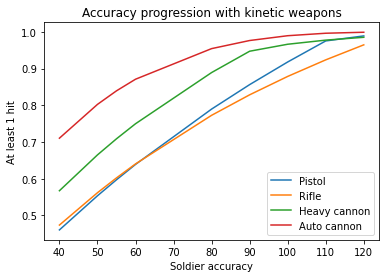

In [16]:
weapon_proficiency_development_one_kinetic = weapon_proficiency_development_one.loc[ ["pistol", "rifle", "heavy_cannon", "auto_cannon"] ]
weapon_proficiency_development_one_kinetic = weapon_proficiency_development_one_kinetic.sort_values(by=["at_least_one"])
weapon_proficiency_development_one_kinetic = weapon_proficiency_development_one_kinetic.unstack(level=0)
ax = weapon_proficiency_development_one_kinetic.plot(title="Accuracy progression with kinetic weapons")
ax.legend(["Pistol", "Rifle", "Heavy cannon", "Auto cannon"]);
ax.set_xlabel("Soldier accuracy")
ax.set_ylabel("At least 1 hit")

## Melee

Text(0, 0.5, 'At least 1 hit')

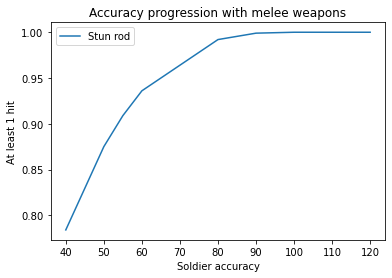

In [17]:
weapon_proficiency_development_one_melee = weapon_proficiency_development_one.loc[ ["stun_rod"] ]
weapon_proficiency_development_one_melee = weapon_proficiency_development_one_melee.sort_values(by=["at_least_one"])
weapon_proficiency_development_one_melee = weapon_proficiency_development_one_melee.unstack(level=0)
ax = weapon_proficiency_development_one_melee.plot(title="Accuracy progression with melee weapons")
ax.legend(["Stun rod"]);
ax.set_xlabel("Soldier accuracy")
ax.set_ylabel("At least 1 hit")

## Explosive

Text(0, 0.5, 'At least 1 hit')

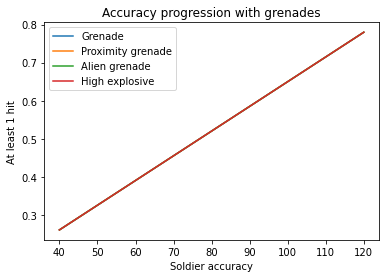

In [18]:
weapon_proficiency_development_one_grenade = weapon_proficiency_development_one.loc[ ["grenade", "proximity_grenade", "alien_grenade", "high_explosive"] ]
weapon_proficiency_development_one_grenade = weapon_proficiency_development_one_grenade.sort_values(by=["at_least_one"])
weapon_proficiency_development_one_grenade = weapon_proficiency_development_one_grenade.unstack(level=0)
ax = weapon_proficiency_development_one_grenade.plot(title="Accuracy progression with grenades")
ax.legend(["Grenade", "Proximity grenade", "Alien grenade", "High explosive"]);
ax.set_xlabel("Soldier accuracy")
ax.set_ylabel("At least 1 hit")

Text(0, 0.5, 'At least 1 hit')

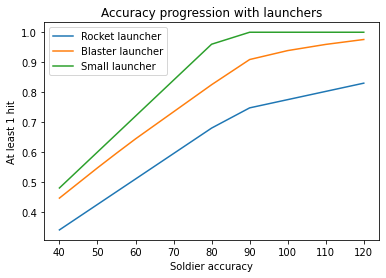

In [19]:
weapon_proficiency_development_one_launcher = weapon_proficiency_development_one.loc[ ["rocket_launcher", "blaster_launcher", "small_launcher"] ]
weapon_proficiency_development_one_launcher = weapon_proficiency_development_one_launcher.sort_values(by=["at_least_one"])
weapon_proficiency_development_one_launcher = weapon_proficiency_development_one_launcher.unstack(level=0)
ax = weapon_proficiency_development_one_launcher.plot(title="Accuracy progression with launchers")
ax.legend(["Rocket launcher", "Blaster launcher", "Small launcher"]);
ax.set_xlabel("Soldier accuracy")
ax.set_ylabel("At least 1 hit")

## Laser

Text(0, 0.5, 'At least 1 hit')

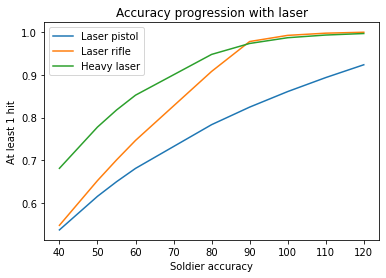

In [20]:
weapon_proficiency_development_one_laser = weapon_proficiency_development_one.loc[ ["laser_pistol", "laser_rifle", "heavy_laser"] ]
weapon_proficiency_development_one_laser = weapon_proficiency_development_one_laser.sort_values(by=["at_least_one"])
weapon_proficiency_development_one_laser = weapon_proficiency_development_one_laser.unstack(level=0)
ax = weapon_proficiency_development_one_laser.plot(title="Accuracy progression with laser")
ax.legend(["Laser pistol", "Laser rifle", "Heavy laser"]);
ax.set_xlabel("Soldier accuracy")
ax.set_ylabel("At least 1 hit")

## Plasma

Text(0, 0.5, 'At least 1 hit')

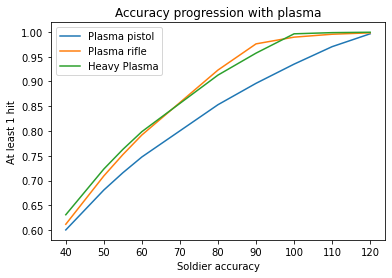

In [21]:
weapon_proficiency_development_one_plasma = weapon_proficiency_development_one.loc[ ["plasma_pistol", "plasma_rifle", "heavy_plasma"] ]
weapon_proficiency_development_one_plasma = weapon_proficiency_development_one_plasma.sort_values(by=["at_least_one"])
weapon_proficiency_development_one_plasma = weapon_proficiency_development_one_plasma.unstack(level=0)
ax = weapon_proficiency_development_one_plasma.plot(title="Accuracy progression with plasma")
ax.legend(["Plasma pistol", "Plasma rifle", "Heavy Plasma"]);
ax.set_xlabel("Soldier accuracy")
ax.set_ylabel("At least 1 hit")

## Tank

Text(0, 0.5, 'At least 1 hit')

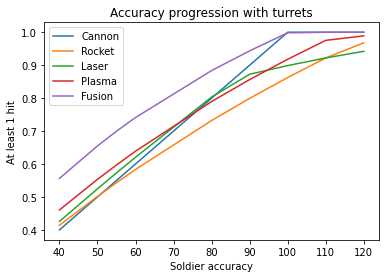

In [22]:
weapon_proficiency_development_one_turret = weapon_proficiency_development_one.loc[ ["cannon_turret", "rocket_turret", "laser_turret", "plasma_turret", "fusion_turret"] ]
weapon_proficiency_development_one_turret = weapon_proficiency_development_one_turret.sort_values(by=["at_least_one"])
weapon_proficiency_development_one_turret = weapon_proficiency_development_one_turret.unstack(level=0)
ax = weapon_proficiency_development_one_turret.plot(title="Accuracy progression with turrets")
ax.legend(["Cannon", "Rocket", "Laser", "Plasma", "Fusion"]);
ax.set_xlabel("Soldier accuracy")
ax.set_ylabel("At least 1 hit")

## Weapon Accuracy Comparison

Using an average soldier Accuracy of 50.

### On Average

Text(0, 0.5, 'Chance to hit')

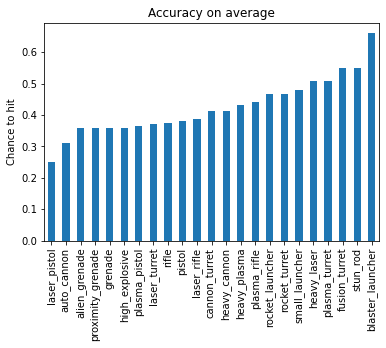

In [23]:
weapon_proficiency_development_average_middle = weapon_proficiency_development_average.xs(55, level="soldier_accuracy")
weapon_proficiency_development_average_middle = weapon_proficiency_development_average_middle.sort_values(by=["final_accuracy"])
ax = weapon_proficiency_development_average_middle.plot.bar(title="Accuracy on average", legend=False)
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("Chance to hit")

### At Least One

Text(0, 0.5, 'At least 1 hit')

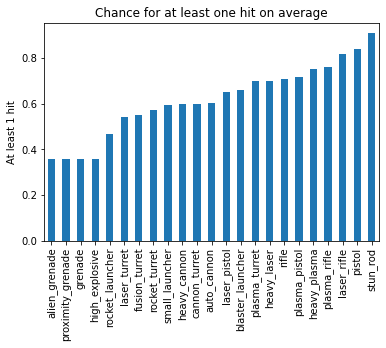

In [24]:
weapon_proficiency_development_one_middle = weapon_proficiency_development_one.xs(55, level="soldier_accuracy")
weapon_proficiency_development_one_middle = weapon_proficiency_development_one_middle.sort_values(by=["at_least_one"])
ax = weapon_proficiency_development_one_middle.plot.bar(title="Chance for at least one hit on average", legend=False)
ax.xaxis.get_label().set_visible(False)
ax.set_ylabel("At least 1 hit")